In [1]:
import sys
sys.path.append('../scripts')

import numpy as np
import pandas as pd

from yahoo_stock_data import YahooStockData
from data_handler_lstm import DataHandler_LSTM
from lstm import AlgoLSTM

In [2]:
START_DATE = '2000-01-01'
TARGET     = 'High'
TIMEFRAME  = -1
LOG_RETURN = True
TEST_SIZE  = 0.2
WINDOW_SIZE = 2
NUM_EPOCHS = 4
PATH_TO_SENT_DATA = '../../data/sentiment_data.csv'
POSITIVE_SENTIMENT_THRESH = 0.105

In [3]:
ticker = 'MSFT'
si_from_yahoo = YahooStockData(ticker)
si_data = si_from_yahoo.get_data(START_DATE)
si_data.reset_index(inplace=True)
si_data = si_data.astype({'Volume': 'float64'}, copy=False) # required for MinMaxScaler
# si_data.to_csv(ticker + '.csv', index=False)
# si_data = pd.read_csv(ticker + '.csv')

[*********************100%***********************]  1 of 1 completed


In [4]:
sent_data = pd.read_csv(PATH_TO_SENT_DATA)
sent_data['Date'] = pd.to_datetime(sent_data['Date'])
sent_data = sent_data[['Date', 'compound']]
sent_data['compound'] = sent_data['compound'].apply(lambda x : 1 if x >= POSITIVE_SENTIMENT_THRESH else 0)
sent_data['compound'] = sent_data['compound'].astype('float64') # required for MinMaxScaler
merged_data = si_data.merge(sent_data, on=['Date'])

assert(merged_data.shape[0] == si_data.shape[0])
assert(merged_data.shape[1] == si_data.shape[1]+1)

In [5]:
data_handler = DataHandler_LSTM(merged_data, TARGET, TIMEFRAME, LOG_RETURN, TEST_SIZE, WINDOW_SIZE, use_sentiment=True)
algo_lstm = AlgoLSTM(data_handler, NUM_EPOCHS)

# Training samples: 4442  # val samples: 555  # test samples: 556


2022-01-27 01:29:45.242440: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 01:29:45.772110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5395 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-01-27 01:29:45.772545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


Epoch 1/4


2022-01-27 01:29:47.492834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-01-27 01:29:47.593616: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4440/4440 [==============================] - 38s 8ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 2/4
4440/4440 [==============================] - 36s 8ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/4
4440/4440 [==============================] - 36s 8ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 4/4
4440/4440 [==============================] - 37s 8ms/step - loss: 0.0023 - val_loss: 0.0016


In [6]:
df_concatenated = algo_lstm.get_forecasts()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 554/554 [00:16<00:00, 34.62it/s]


4440 553 554
(5547, 10)


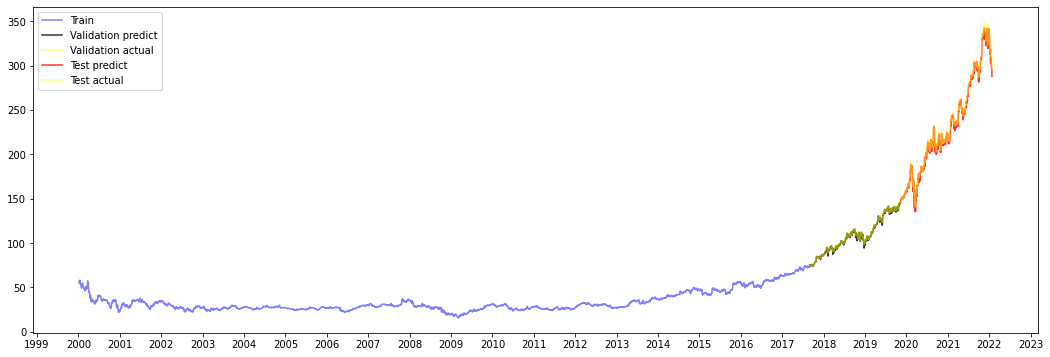

In [7]:
df_forecast, accuracy = data_handler.process_forecasts(df_concatenated)

In [8]:
# Accuracy
pd.DataFrame(accuracy)

,mse,rmse,mae,mape
train,0.258851,0.508774,0.317868,0.982669
validation,2.104809,1.450796,0.990673,0.894813
test,18.215022,4.267906,3.157586,1.391880


In [9]:
# Predicted value
df_forecast.iloc[-1]['test_pred']

296.13067862888903